In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2002 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_02(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata02 = pd.read_csv("perlist02_s.csv")
    f = perdata02['f']
    per = perdata02['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata02)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m02=Minuit(twi_minus_loglikelihood_02,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_log_poisson=0.1,
         limit_log_A=(-3,-1), limit_log_f_b=(-7,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m02.migrad()

pprint(m02.fval)

FCN = 3214.7020175078787 
 TOTAL NCALL = 415 
 NCALLS = 415 
 
 
 EDM = 8.12705216436873e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.5873,0.177496,,,-3,-1,No
1,log_f_b,-3.63843,0.226468,,,-7,-2,No
2,alpha_H,2.65453,0.476155,,,1,5,No
3,poisson,2.57541,0.127694,,,0,5,No


3214.7020175078787


In [4]:
perdata02 = pd.read_csv("perlist02_s.csv")
f_02 = perdata02['f']
per_02 = perdata02['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,log_poisson = m02.values[0],m02.values[1],m02.values[2],m02.values[3]

model_02 = []
R_obs_02 = []
T_SSE_obs_02 = 0
f_length_02 = len(f_02)
for i in range(f_length_02):
    model_02.append(((f_02[i]**(-alpha_L))/(1+(f_02[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
    R_obs_02.append(2*per_02[i]/model_02[i])
    T_SSE_obs_02 += (((per_02[i]-model_02[i])/model_02[i])**2)

# 两个统计量
T_R_obs_02 = max(R_obs_02)
print ("T_R =", T_R_obs_02)
print ("T_SSE =", T_SSE_obs_02)

T_R = 27.998941964049518
T_SSE = 767.8039011355497


In [5]:
# 5000条光变曲线

df = 0.01/f_length_02
N = 2*f_length_02
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_02]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_02):
        R_simu.append(2*per_simu[i]/model_02[i])
        T_SSE_simu += (((per_simu[i]-model_02[i])/model_02[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_02:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_02:
        n_TSSE += 1

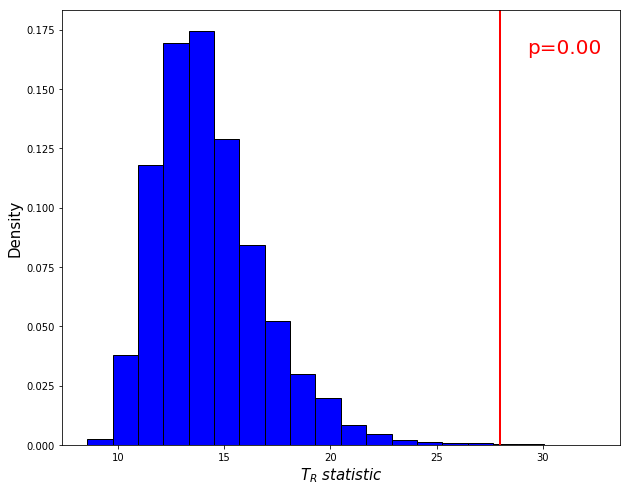

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_02, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

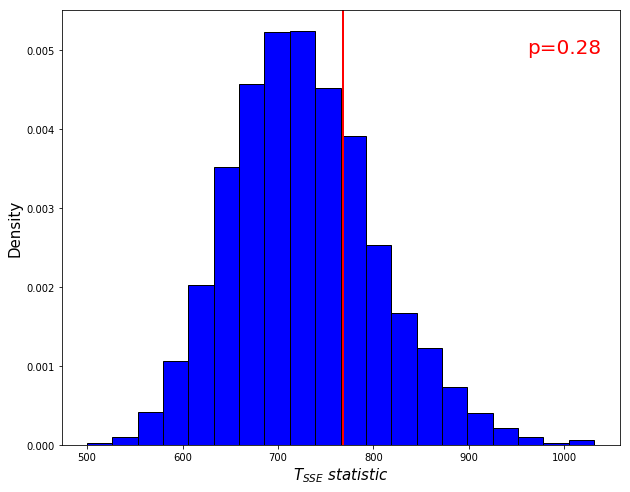

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_02, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2010(1) 统计分析

In [8]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_101(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata101 = pd.read_csv("perlist101_s.csv")
    f = perdata101['f']
    per = perdata101['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata101)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
m101=Minuit(twi_minus_loglikelihood_101,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_log_poisson=0.1,
         limit_log_A=(-3,0), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m101.migrad()

pprint(m101.fval)

FCN = 4341.438041706932 
 TOTAL NCALL = 445 
 NCALLS = 445 
 
 
 EDM = 5.157836451727809e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.07044,0.194175,,,-3,0,No
1,log_f_b,-3.92451,0.219184,,,-5,-2,No
2,alpha_H,2.60276,0.285884,,,1,5,No
3,poisson,2.34979,0.104247,,,0,5,No


4341.438041706932


In [10]:
perdata101 = pd.read_csv("perlist101_s.csv")
f_101 = perdata101['f']
per_101 = perdata101['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,log_poisson = m101.values[0],m101.values[1],m101.values[2],m101.values[3]

model_101 = []
R_obs_101 = []
T_SSE_obs_101 = 0
f_length_101 = len(f_101)
for i in range(f_length_101):
    model_101.append(((f_101[i]**(-alpha_L))/(1+(f_101[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
    R_obs_101.append(2*per_101[i]/model_101[i])
    T_SSE_obs_101 += (((per_101[i]-model_101[i])/model_101[i])**2)
    
# 两个统计量
T_R_obs_101 = max(R_obs_101)
print ("T_R =", T_R_obs_101)
print ("T_SSE =", T_SSE_obs_101)

T_R = 20.852675749321904
T_SSE = 1093.2520426304668


In [11]:
# 5000条光变曲线

df = 0.01/f_length_101
N = 2*f_length_101
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_101]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_101):
        R_simu.append(2*per_simu[i]/model_101[i])
        T_SSE_simu += (((per_simu[i]-model_101[i])/model_101[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_101:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_101:
        n_TSSE += 1

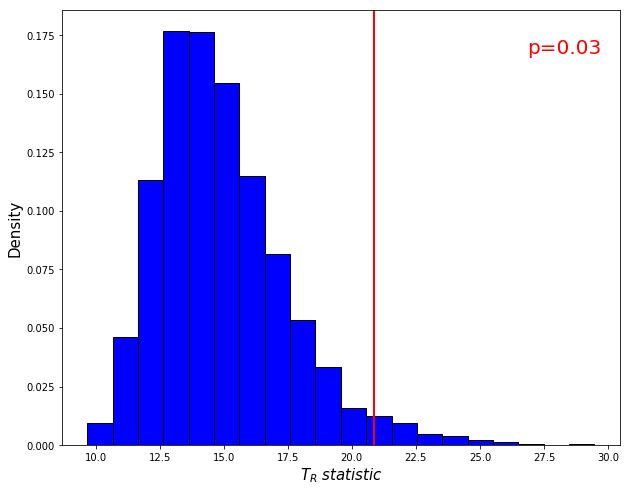

In [12]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_101, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

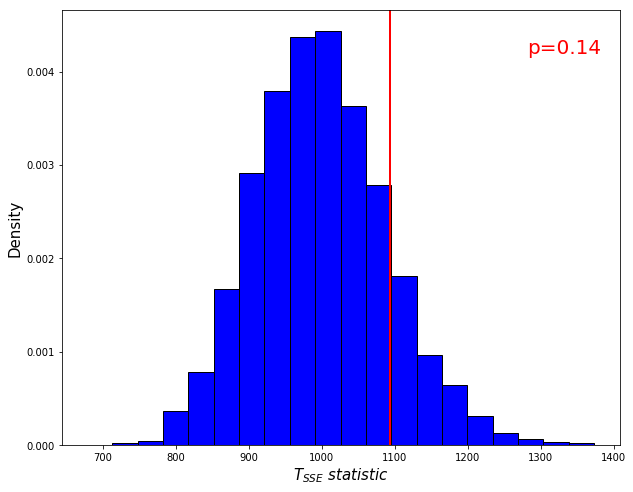

In [13]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_101, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2007(2) 统计分析

In [14]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_072(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata072 = pd.read_csv("perlist072_s.csv")
    f = perdata072['f']
    per = perdata072['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata072)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [15]:
m072=Minuit(twi_minus_loglikelihood_072,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_log_poisson=0.1,
         limit_log_A=(-3,0), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m072.migrad()

pprint(m072.fval)

FCN = 2066.337254667657 
 TOTAL NCALL = 337 
 NCALLS = 337 
 
 
 EDM = 1.0408703449696677e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-0.886146,0.270705,,,-3,0,No
1,log_f_b,-3.74142,0.290546,,,-5,-2,No
2,alpha_H,2.93358,0.575775,,,1,5,No
3,poisson,3.88198,0.248174,,,0,5,No


2066.337254667657


In [16]:
perdata072 = pd.read_csv("perlist072_s.csv")
f_072 = perdata072['f']
per_072 = perdata072['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,log_poisson = m072.values[0],m072.values[1],m072.values[2],m072.values[3]

model_072 = []
R_obs_072 = []
T_SSE_obs_072 = 0
f_length_072 = len(f_072)
for i in range(f_length_072):
    model_072.append(((f_072[i]**(-alpha_L))/(1+(f_072[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
    R_obs_072.append(2*per_072[i]/model_072[i])
    T_SSE_obs_072 += (((per_072[i]-model_072[i])/model_072[i])**2)
    
# 两个统计量
T_R_obs_072 = max(R_obs_072)
print ("T_R =", T_R_obs_072)
print ("T_SSE =", T_SSE_obs_072)

T_R = 10.029627820257598
T_SSE = 346.6831492023602


In [17]:
# 5000条光变曲线

df = 0.01/f_length_072
N = 2*f_length_072
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_072]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_072):
        R_simu.append(2*per_simu[i]/model_072[i])
        T_SSE_simu += (((per_simu[i]-model_072[i])/model_072[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_072:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_072:
        n_TSSE += 1

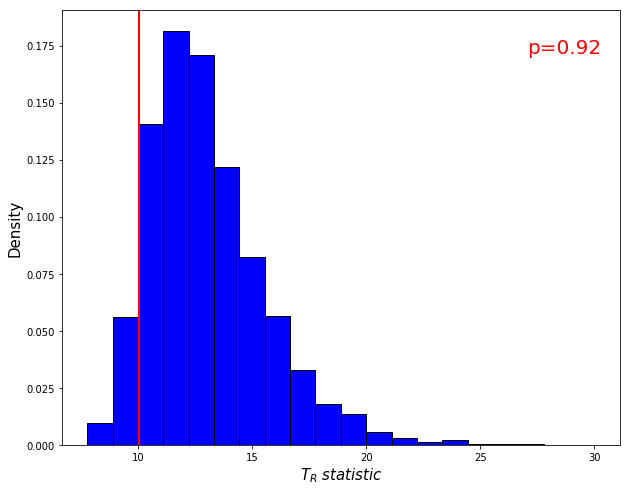

In [18]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_072, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

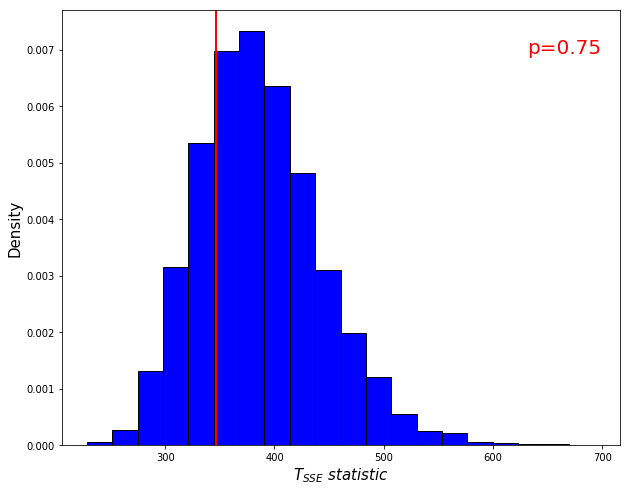

In [19]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_072, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()